# Extracción de términos informativos

Los conceptos de la teoría de la información pueden ser de gran utilidad para diferentes tareas de la RI. En particular, pueden cuantificar la información de los tokens dentro de colecciones. Sin embargo, la información con base a la probabilidad de aparición del token no es la mejor forma de establecer palabras clave.

Aquí revisamos una primera aproximación a la extracción de palabras clave a partir de sus distribución a través de los diferentes documentos dentro de una colección.

In [1]:
from nltk.corpus import brown
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain
from wordcloud import WordCloud
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Documentos y términos

Definimos cuáles serán los documentos y cuáles los términos con los que trabajaremos. Asimismo, tenemos que estos términos pertenencen a un conjunto de tópicos específico.

In [3]:
#Algoritmo de stemming
stemmer = SnowballStemmer('english')

#Recupera ids de ciertos tópicos en el corpus
doc_ids = brown.fileids(categories=['science_fiction', 'learned'] ) #brown.categories()) #['science_fiction', 'learned'])

#Guarda los documentos
documents = defaultdict(list)
for docID in doc_ids:
    #Recupera los tokens
    tokens = brown.words(docID)
    for w in tokens:
        #Guarda los tokens alfanuméricos
        if w.isalpha() != False:
            documents[docID].append(w.lower())

#Guarda los terminos
terms = list(chain(*[tokens for tokens in documents.values()]))
#Frecuencia de terminos
term_frequencies = Counter(terms)

In [4]:
term_list = pd.DataFrame(sorted(term_frequencies.items(), key=itemgetter(1), reverse=True), 
                         columns=['Token','Frequency'])

term_list = term_list.set_index(term_list['Token'])
term_list.pop('Token')
term_list

,Frequency
Token,
the,13260
of,7781
and,4576
in,4261
to,4255
...,...
alvarez,1
commingled,1
prisoner,1


### Información de términos

Con base a la frecuencia de los términos, podemos establecer su probabilidad $p(w_i)$, $i=1,2,...,n$. Asimismo, podemos establecer la información que estos términos tienen en base a esta distribución como:

$$I(w_i) = -\log_2 p(w_i)$$

Como veremos, esta información es inversamente proporcional a la probabilidad:

/home/mijangos/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


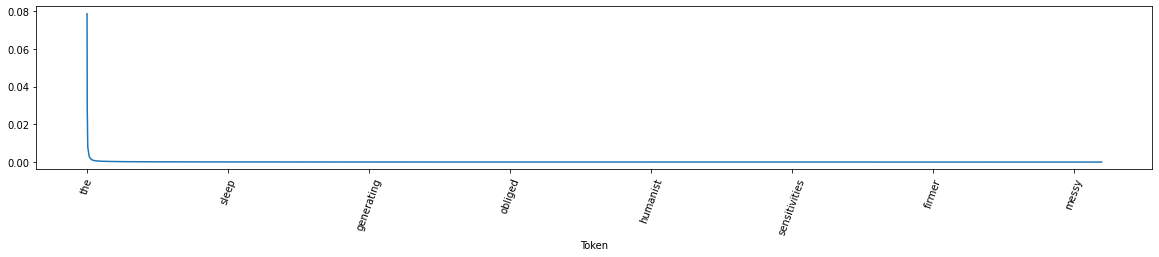

In [5]:
#Calcular probabilidad
term_list['Probability'] = term_list/term_list.sum()

#Visualizar las probabilidades
term_list['Probability'].sort_values(ascending=False).plot(figsize=(20,3), rot=70)
plt.show()

/home/mijangos/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


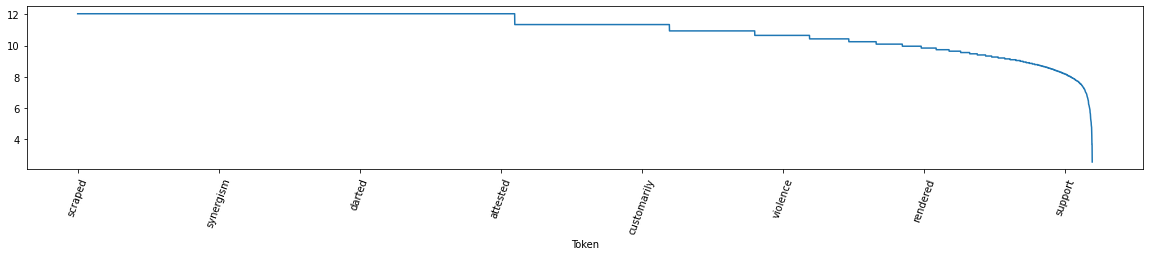

In [6]:
#Calcular información
term_list['Information'] = -np.log(term_list['Probability'])

#Visualizar la información
term_list['Information'].sort_values(ascending=False).plot(figsize=(20,3), rot=70)
plt.show()

In [7]:
#Correlación de valores
term_list.corr()

,Frequency,Probability,Information
Frequency,1.000000,1.000000,-0.260225
Probability,1.000000,1.000000,-0.260225
Information,-0.260225,-0.260225,1.000000


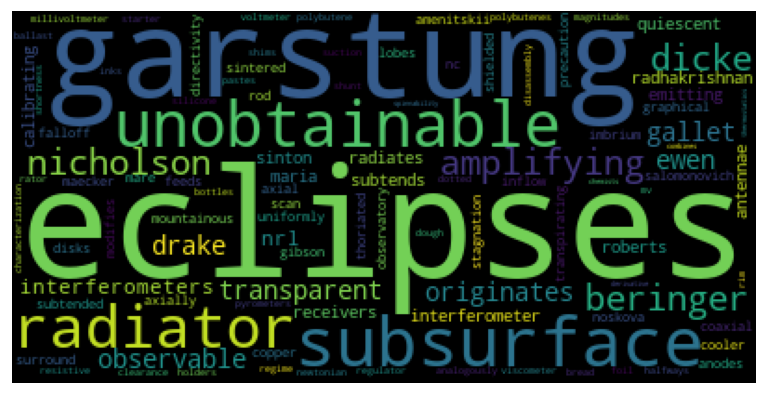

In [8]:
#Visualizar como nube de palabras
mycloud = WordCloud()
mycloud.generate_from_frequencies(term_list['Information'].to_dict())

plt.figure(figsize=(8,10), dpi=120)
plt.imshow(mycloud)
plt.axis("off")
plt.show()

### Representatividad

La información así determonada, sin embargo, no determina de manera precisa los candidatos a palabras clave puesto que los elementos menos probables tienen mayor información.

Podemos utilizar la teoría de la información para cuantificar la representatividad de los tópicos en nuestra coleeción.

Siendo $f_{i,j}$ la frecuencia del término $i$ en el tópico $j$, calculamos la probabilidad de los tópicos como:

$$r_{j} = \frac{\sum_i f_{i,j}}{\sum_j \sum_i f_{i,j}}$$

In [9]:
#Diccionario de tópicos y tokens
topics = defaultdict(list)

for docID, token_list in documents.items():
    #Tomamos la información del nombre del 
    #documento que corresponde al tópico al que pertenece.
    topic_name = brown.categories(docID)[0]
    #Por cada tópico agregamos la lista de tokens
    topics[topic_name].append(token_list)

#Diccionario de tópicos-tokens
topics = {topic:list(chain(*tokens)) for topic, tokens in topics.items()}

topic_frequency = {g: Counter(token_list) for g, token_list in topics.items()}
#Suma de las frecuencias absolutas de los términos
total_term_freq = sum(term_frequencies.values())

#Diccionario de tamaños de tópicos
topic_size =  {}
for topic, types in topic_frequency.items():
    #Suma de frecuencias de términos en tópicos
    freq_topic_j = sum(types.values())
    #Tamaño reativo del género
    r_j = freq_topic_j/total_term_freq
    #Guardamos en el diccionario.
    topic_size[topic] = r_j

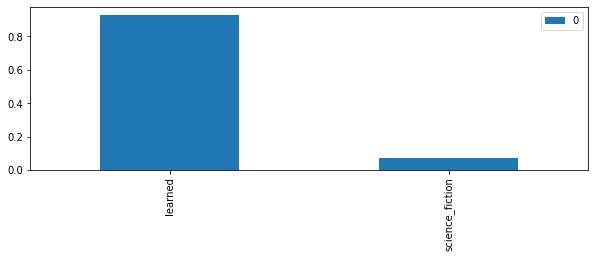

In [10]:
pd.DataFrame({topic:[size] for topic, size in topic_size.items()}).T.plot.bar(figsize=(10,3))
plt.show()

El valor $r_{j}$ es una probabilidad, la probabilidad del tópico dada la colección. Por tanto, podemos estimar un valor de entropía sobre esta variable: $$H(R) = -\sum_j r_j \log_N r_{j}$$

Entre más alto es el valor de entropía, más cerca estamos a una distribución uniforma de los tópicos.

In [11]:
#Vector de probabilidades
p = np.array(list(topic_size.values()))
#Entropía
H = -p@np.log(p)/np.log(len(topic_size))

print('Entropía de la distribución de tópicos:\n{}'.format(H))

Entropía de la distribución de tópicos:
0.3647333220911832


### 